<a href="https://colab.research.google.com/github/anagjurchinova/DataScience_2025/blob/main/Obesity_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

## Obesity Analysis


# Dataset Description

## Attributes

- id: represents a unique identifier for each participant or record in the dataset.
- Gender: Represents the gender of the individual.
- Age: Indicates the age of the individual.
- Height - Represents the height of the individual.
- Weight: Represents the weight of the individual.
- FCVC Frequency of Consumption of Vegetables
- NCP - Number of Main Meals per Day
- SMOKE - Indicates whether the individual smokes
- CH2O - Consumption of Water
- TUE - Time Using Electronic Devices
- MTRANS - Mode of Transportation
- NObeyesdad - Nutritional Obesity Status, obesity class

### Target variable
- FAF Frequency of Physical Activity

# Read the dataset

In [54]:
data = pd.read_csv('/content/sample_data/obesity.csv')
data.drop(columns=['Unnamed: 0', 'id'], axis=1, inplace=True)
data.head()

,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,2.0,2.983297,no,2.763573,0.000000,0.976473,Public_Transportation,NaN
1,Female,18.000000,1.560000,57.000000,2.0,3.000000,no,NaN,NaN,1.000000,Automobile,Normal_Weight
2,Female,18.000000,NaN,50.165754,NaN,1.411685,no,NaN,0.866045,NaN,Public_Transportation,Insufficient_Weight
3,NaN,20.952737,1.710730,131.274851,3.0,3.000000,no,1.674061,1.467863,0.780199,Public_Transportation,NaN
4,Male,31.641081,1.914186,NaN,NaN,1.971472,no,NaN,1.967973,0.931721,Public_Transportation,Overweight_Level_II


Explore the dataset using visualizations of your choice.

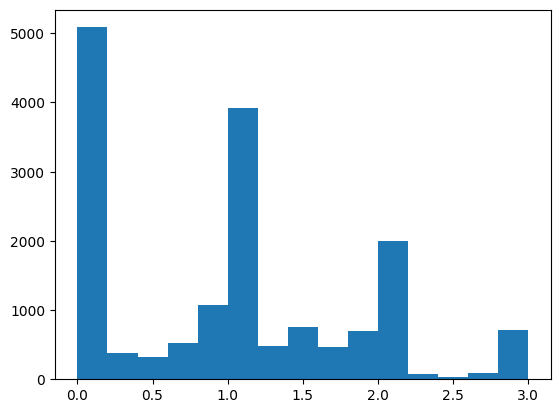

In [33]:
plt.hist(data['FAF'], bins=15)
plt.show()

In [34]:
data['FAF'].isnull().sum()

4139

In [35]:
# Dropping rows with missing values in target
data.dropna(subset=['FAF'], axis=0, inplace=True)
data['FAF'].isnull().sum()

0

In [23]:
def visualize(data, columns, numerical, color):
  plt.figure(figsize=(14,4))
  for i in range(0,len(columns)):
    plt.subplot(1,len(columns),i+1)
    if numerical:
      plt.hist(data[columns[i]], bins=15, color=color)
    else:
      counts = data.groupby(columns[i]).size()
      plt.bar(counts.index, counts, color=color)
    plt.title(columns[i])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      16634 non-null  object 
 1   Age         16608 non-null  float64
 2   Height      16667 non-null  float64
 3   Weight      16477 non-null  float64
 4   FCVC        16641 non-null  float64
 5   NCP         16697 non-null  float64
 6   SMOKE       16648 non-null  object 
 7   CH2O        16597 non-null  float64
 8   FAF         16619 non-null  float64
 9   TUE         16611 non-null  float64
 10  MTRANS      16600 non-null  object 
 11  NObeyesdad  16625 non-null  object 
dtypes: float64(8), object(4)
memory usage: 1.9+ MB


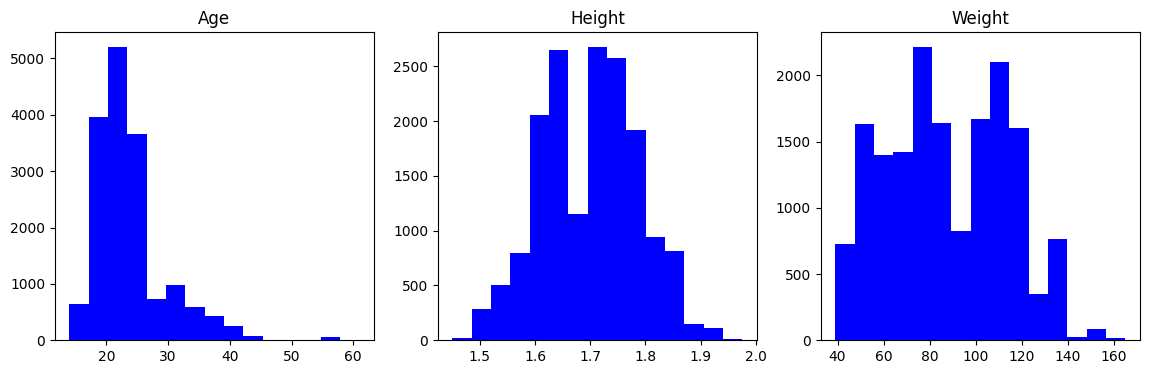

In [24]:
visualize(data, ['Age', 'Height', 'Weight'], True, 'blue')
# Only height is almost normally distributed, but still not.

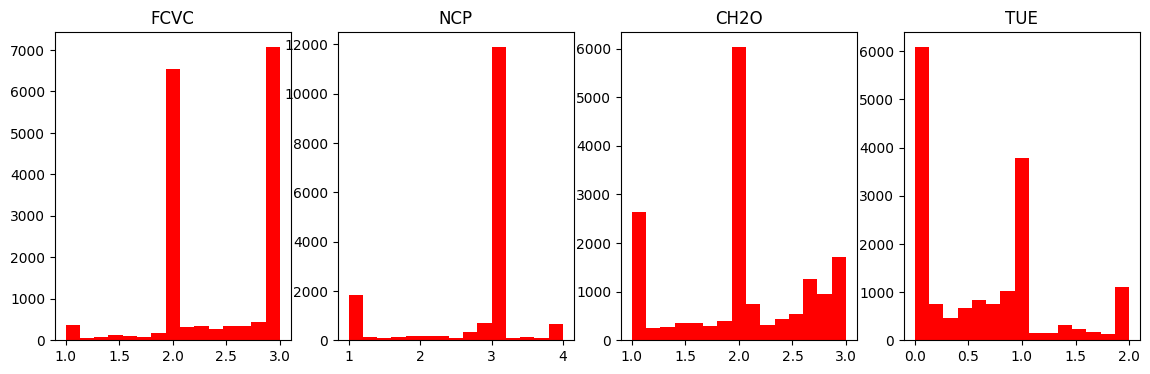

In [22]:
visualize(data, ['FCVC', 'NCP', 'CH2O', 'TUE'], True, 'red')
# Not normally distributed

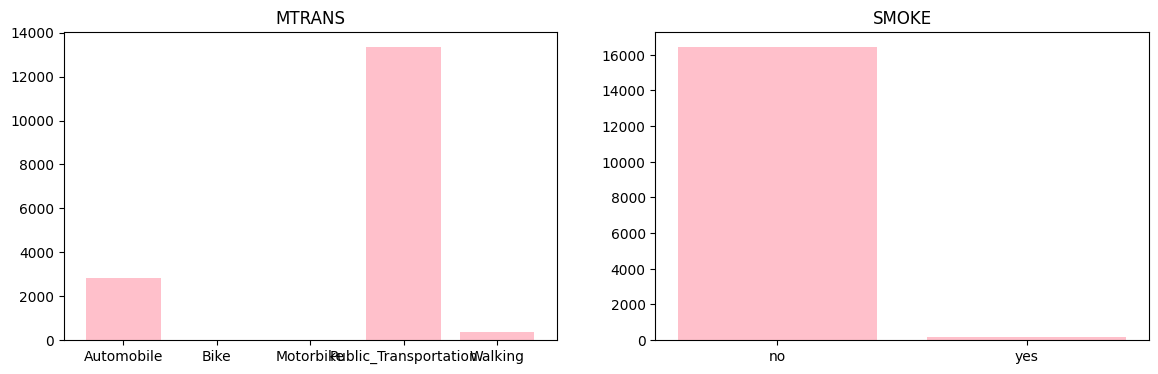

In [27]:
visualize(data, ['MTRANS', 'SMOKE'], False, 'pink')
# Almost every person does not smoke, so we can use frequent imputer.

## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [39]:
data.isnull().mean() * 100

,0
Gender,19.886876
Age,19.904928
Height,19.628136
Weight,20.440460
FCVC,19.947049
NCP,19.477706
SMOKE,19.814670
CH2O,20.085444
FAF,0.000000
TUE,20.043324


In [59]:
def label(data, columns):
  data_copy = data.copy()
  le = LabelEncoder()
  for column in columns:
    non_nans = data_copy[column].dropna()
    le.fit(non_nans)
    data_copy[column] = data_copy[column].apply(lambda x: le.transform([x])[0] if pd.notna(x) else x)

  return data_copy

In [56]:
def encode_smokers(x):
  if type(x) == float:
    return x
  if 'yes' in x:
    return 1
  if 'no' in x:
    return 0
  else: # Keep the nulls first, handle them later
    return x

In [57]:
data['SMOKE'] = data['SMOKE'].apply(encode_smokers)

In [58]:
data['SMOKE']

,SMOKE
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
20753,0.0
20754,0.0
20755,0.0
20756,NaN


In [60]:
data_encoded = label(data, ['NObeyesdad', 'Gender', 'MTRANS'])
data_encoded.head()

,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,1.0,24.443011,1.699998,81.669950,2.0,2.983297,0.0,2.763573,0.000000,0.976473,3.0,NaN
1,0.0,18.000000,1.560000,57.000000,2.0,3.000000,0.0,NaN,NaN,1.000000,0.0,1.0
2,0.0,18.000000,NaN,50.165754,NaN,1.411685,0.0,NaN,0.866045,NaN,3.0,0.0
3,NaN,20.952737,1.710730,131.274851,3.0,3.000000,0.0,1.674061,1.467863,0.780199,3.0,NaN
4,1.0,31.641081,1.914186,NaN,NaN,1.971472,0.0,NaN,1.967973,0.931721,3.0,6.0


## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts. To achieve this use the `missingno` library.

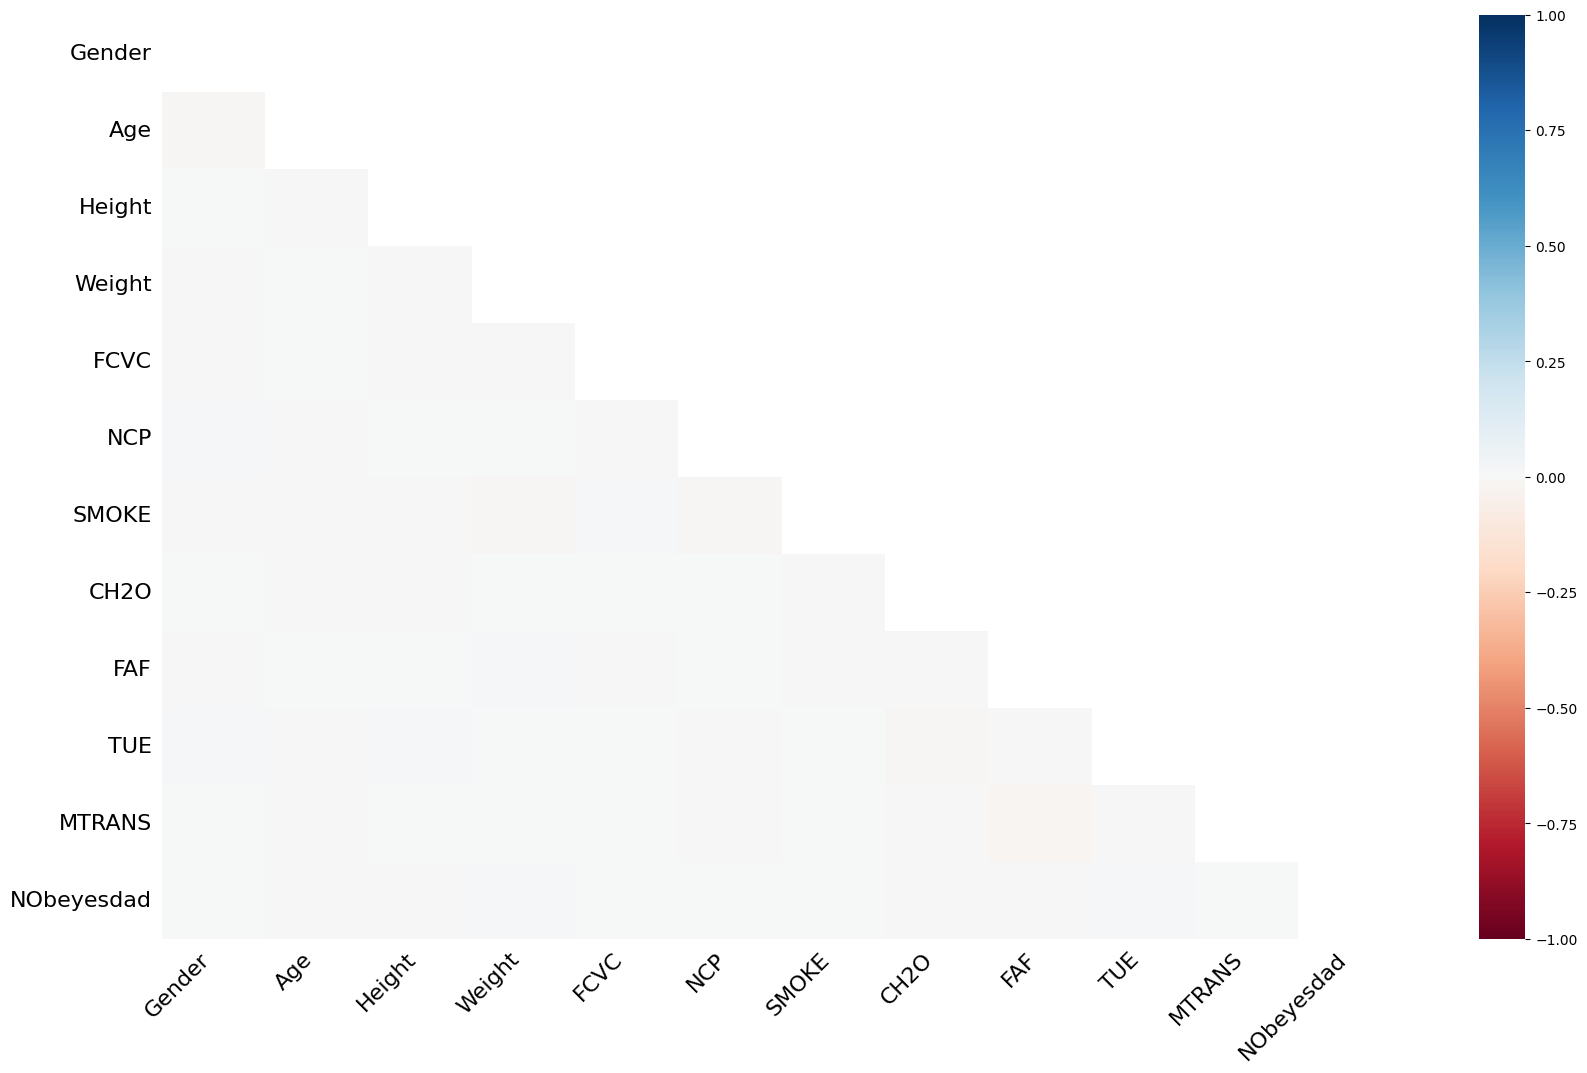

In [61]:
msno.heatmap(data_encoded)
plt.show()
# The missing values are not correlated

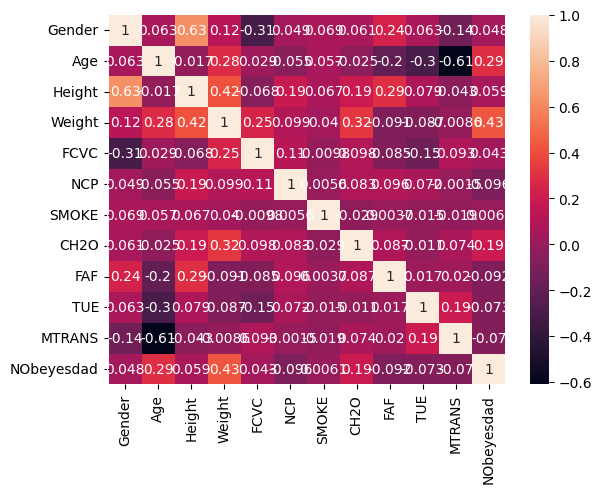

In [62]:
sns.heatmap(data_encoded.corr(), annot=True)
plt.show()

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [63]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_encoded[['Height', 'Gender']])
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(scaled_data)

data_encoded[['Height', 'Gender']] = imputed_data

In [64]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_encoded[['Age', 'MTRANS']])
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(scaled_data)

data_encoded[['Age', 'MTRANS']] = imputed_data

In [65]:
data_encoded.isnull().mean() * 100

,0
Gender,0.000000
Age,0.000000
Height,0.000000
Weight,20.623374
FCVC,19.833317
NCP,19.563542
SMOKE,19.799595
CH2O,20.045284
FAF,19.939301
TUE,19.977840


In [66]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice = IterativeImputer()
imputed_values = mice.fit_transform(data_encoded[['Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])
data_encoded[['Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = imputed_values

In [67]:
# 0 are non-smokers, we are imputing 0 as a constant because almost everyone is a non-smoker, so we are going to assume the missing values as non-smokers.
data_encoded['SMOKE'] = data_encoded['SMOKE'].fillna(0)

In [68]:
data_encoded.isnull().mean() * 100

,0
Gender,0.000000
Age,0.000000
Height,0.000000
Weight,0.000000
FCVC,0.000000
NCP,0.000000
SMOKE,0.000000
CH2O,0.000000
FAF,0.000000
TUE,0.000000


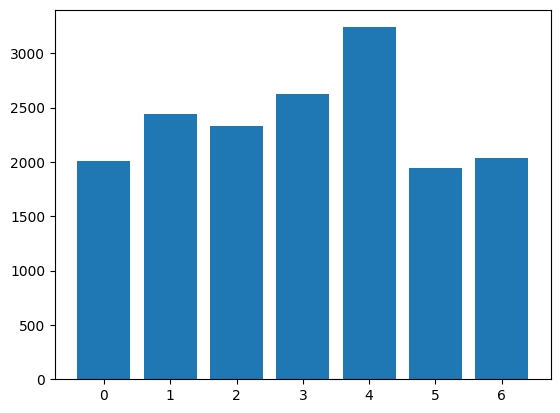

In [70]:
nobeyesdad_counts = data_encoded.groupby('NObeyesdad').size()
plt.bar(nobeyesdad_counts.index, nobeyesdad_counts)
plt.show()

In [73]:
frequent_imputer = SimpleImputer(strategy = 'most_frequent')
data_encoded['NObeyesdad'] = frequent_imputer.fit_transform(data_encoded[['NObeyesdad']]).flatten()

data_encoded.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
FCVC,0
NCP,0
SMOKE,0
CH2O,0
FAF,0
TUE,0


## Feature Preprocessing


Preprocess the features to make them ready for using the model

In [74]:
from sklearn.model_selection import train_test_split
data_copy = data_encoded.copy()
data_copy.drop('FAF', axis=1, inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(data_copy[data_copy.columns],  data_encoded['FAF'], test_size=0.2)

## Hyper-parameter optimization

Train an XGBoost Model, optimize it's hyper-parameters with grid-search and 5-fold cross validation on the training set.

In [79]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'objective' : ['reg:linear'],
    'colsample_bytree' : [0.1, 0.3, 0.5],
    'learning_rate' : [0.001, 0.1, 0.0001, 10],
    'max_depth' : [3, 4, 5],
    'alpha' : [2, 4, 10],
    'n_estimators' : [3, 5, 10]
}
model = XGBRegressor()
grid_search = GridSearchCV(
    estimator=model,
    scoring='r2',
    param_grid=param_grid,
    n_jobs=-1,
    verbose=1,
    cv=5
)
grid_search.fit(X_train, Y_train)

print(f'Best params: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Best params: {'alpha': 2, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'objective': 'reg:linear'}
Best score: 0.2166274424490517


# Cross-validation evaluation

Perform leave-one out cross validation on the entire dataset, with an untrained model with the chosen hyper-parameters from the previous step.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [81]:
model = grid_search.best_estimator_
predictions = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
import numpy as np
print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(predictions, Y_test))))

Mean Absolute Error : 0.7080180614355205
